# Problématique 

Code permettant d'entrainer un modèle de reconnaissance text manuscrit.


# Import

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import re
from os.path import exists
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import string


import letter_detection_utils as ld_util
import preprocessing as pp
import ressources as rss
import modele as mdl
import rendering as rd


In [2]:
# Pour recharger les libs pendant les devs
from importlib import reload 
reload(ld_util)
reload(pp)
reload(rss)
reload(mdl)
reload(rd)

<module 'rendering' from '/Users/davidbeda/Python/Datascientest/projet_OCR_code/OCRpyMAN/notebooks/rendering.py'>

# Chargement du dataframe

In [3]:
# initialisation des variables globales
rss.init()

In [4]:
# Chargement avec tensorflow et dataset par batch

dataset_train, dataset_test, X_test, y_test = ld_util.get_dataset()

dataset_train_canny, dataset_test_canny, X_test_canny, y_test_canny = ld_util.get_dataset(canny=True)

2023-01-24 22:09:40.685631: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
delimiter is deprecated, please use sep instead.


In [5]:
# PROPOSITION DB : initialisation d'un iterator pour afficher différents batchs
batch_id=0
iterator = iter(dataset_train)

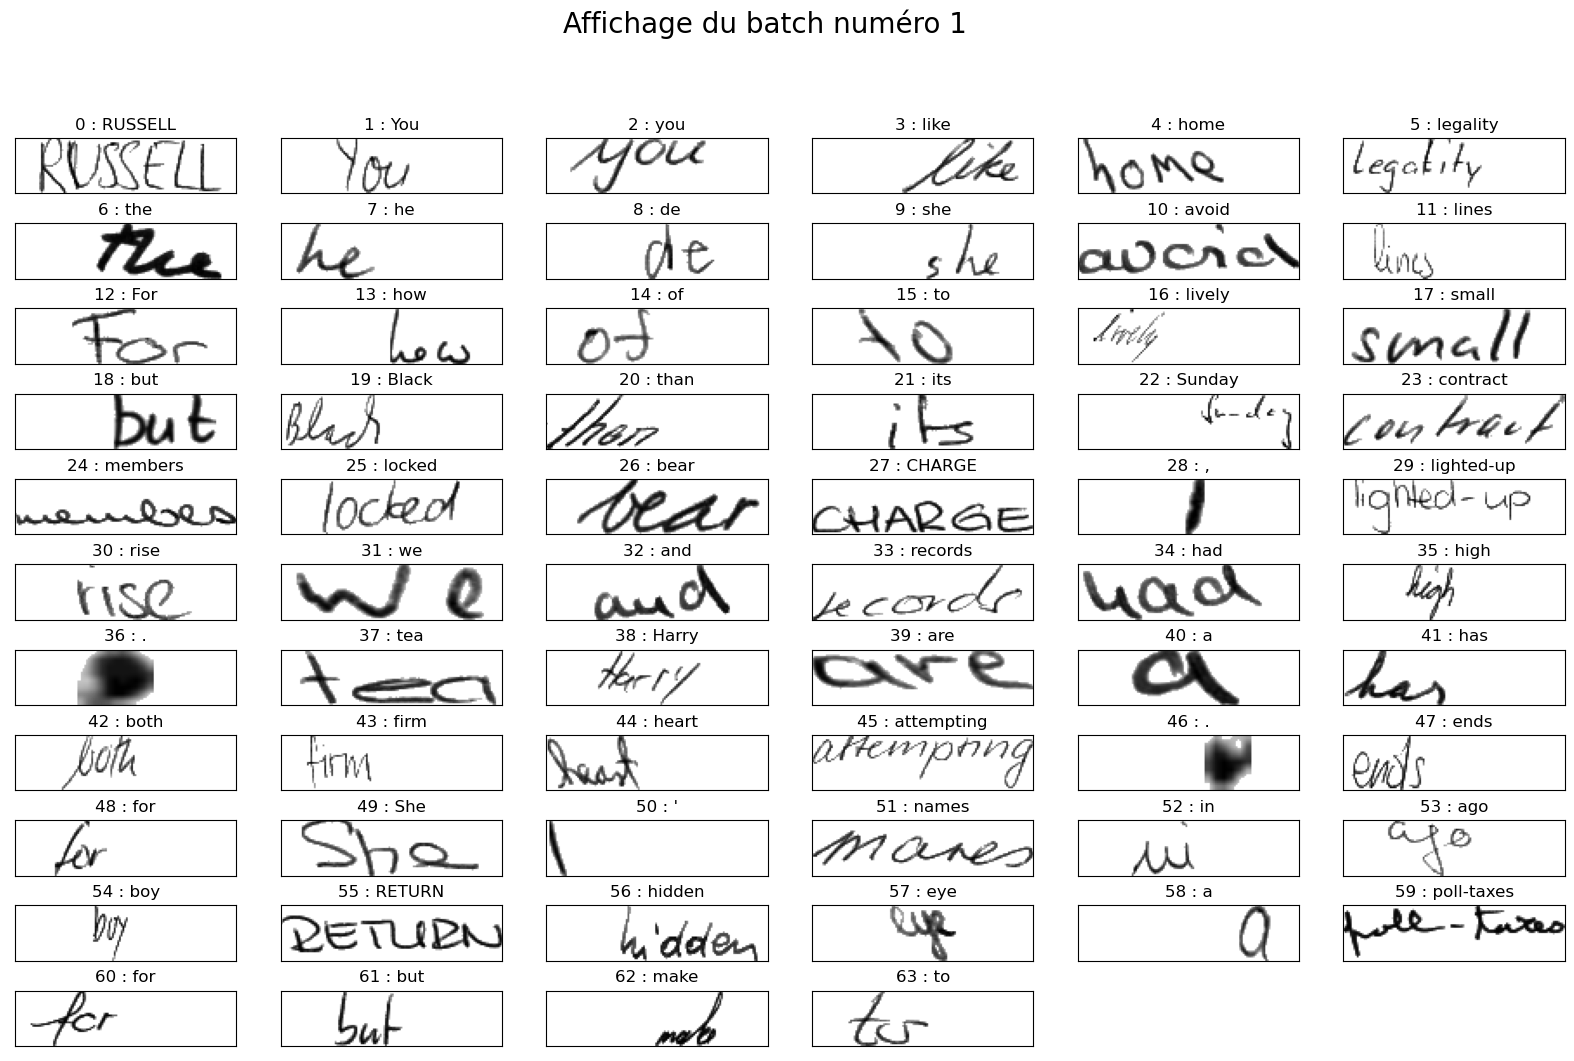

In [6]:
# PROPOSITION DB : lecture des 64 images d'un bacth (le prochain) du dataset d'entrainement

x,y = iterator.get_next()
batch_id +=1
rd.show_iterator_batch(x,y,batch_id)

# Model RNN

### Création Modèle

In [7]:
model = mdl.create_modele()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 128, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 64, 64)       2

In [8]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, reduction=tf.keras.losses.Reduction.SUM, name='ctc'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        label_length = tf.fill([tf.shape(y_true)[0]], tf.shape(y_true)[1])
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=-1)
        return tf.reduce_mean(loss)


early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp_model', 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch'
)

In [9]:
# chargement du model de référence ou nouvel entraintement

new_training = False

if new_training:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss=CTCLoss(), optimizer=optimizer)
    history = model.fit(
        dataset_train,
        validation_data=dataset_test,
        callbacks=[
            early_stop_callback,
            checkpoint_callback
        ],
        epochs=10
    )
else:
    model = tf.keras.models.load_model('../pickle/model_db_ref0', custom_objects={"CTCLoss": CTCLoss})


In [51]:
# OLD
#with open('history.pickle', 'wb') as file_pi:
#     pickle.dump(history.history, file_pi)

#with open('history.pickle', "rb") as file_pi:
#    history = pickle.load(file_pi)

In [10]:
x, y = next(iter(dataset_train))
x.shape

TensorShape([64, 32, 128, 1])

In [11]:
y_pred = model.predict(dataset_test)


149/149 [==============================] - 85s 554ms/step


In [13]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

[(',', "'"),
 ('the', 'the'),
 ('a', '#'),
 ('befire', 'before'),
 ('ald', 'and'),
 ('.', '.'),
 ('gratly', 'greatly'),
 ('about', 'about'),
 ('this', 'this'),
 ('wanfilence', 'confidence')]

In [14]:
# enregistrement du model

save_model = False

if save_model:
    model.save('../pickle/model_db_ref0')

In [15]:
# OLD : Distance de Levenshtein 

#ld_util.levenshtein_distance(['test','text'], ['text','test'])

#lev_abs = ld_util.levenshtein_distance(predicted_transcriptions, y_test)
#lev_rel = lev_abs / len(y_test)

#print('Score Levenshtein absolu : ', lev_abs)
#print('Scode Levenshtein relatif :', lev_rel)

Score Levenshtein absolu :  3867
Scode Levenshtein relatif : 0.40748155953635407


#### Debut du bac à sable. Code à structurer correctement

In [52]:

lev = []
cer = []
acc = []
nb_correction = []

for i in range(len(y_test)):
    lev.append(ld_util.levenshtein_distance(y_test[i], predicted_transcriptions[i]))
    cer.append(lev[i]/len(y_test[i]))
    if predicted_transcriptions[i] == y_test[i]:
        acc.append(1)
    else : acc.append(0)
    nb_correction.append(0)

In [53]:
metric_df_0 = pd.DataFrame(list(zip(y_test, predicted_transcriptions, nb_correction, lev, cer, acc)), columns =['test','prediction','nb_correction','levenshtein', 'cer', 'acc']) 

In [54]:
metric_df_0.head(10)

,test,prediction,nb_correction,levenshtein,cer,acc
0,',",",0,1,1.000000,0
1,the,the,0,0,0.000000,1
2,#,a,0,1,1.000000,0
3,before,befire,0,1,0.166667,0
4,and,ald,0,1,0.333333,0
5,.,.,0,0,0.000000,1
6,greatly,gratly,0,1,0.142857,0
7,about,about,0,0,0.000000,1
8,this,this,0,0,0.000000,1
9,confidence,wanfilence,0,3,0.300000,0


In [55]:
metric_df_0.describe()

,nb_correction,levenshtein,cer,acc
count,9490.0,9490.000000,9490.000000,9490.000000
mean,0.0,0.748367,0.164448,0.592518
std,0.0,1.192995,0.276178,0.491392
min,0.0,0.000000,0.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000
50%,0.0,0.000000,0.000000,1.000000
75%,0.0,1.000000,0.250000,1.000000
max,0.0,12.000000,6.000000,1.000000


In [56]:
# correction orthographique v1, (basique)

import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

WORDS = Counter(words(open('../data/english_words/big.txt').read()))

def P(word, N=sum(WORDS.values())): return WORDS[word] / N

def edits1(word):
    "All edits that are one edit away from `word`."
    # QUESTION A INSTRUIRE SI ON DOIT LAISSER LA PONCTUATION
    letters    = ''.join(rss.charList)
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def known(words): return set(w for w in words if w in WORDS)

def candidates(word): 
    # ORIGINAL :
    #return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
    if len(word) == 1: return word
    elif len(word) ==2: return known([word]) or known(edits1(word)) or [word]
    else : return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]

def correction(word):
    correction = max(candidates(word), key=P)
    if not word.islower() and not word.isupper(): correction = correction.capitalize()
    elif word.isupper() : correction = correction.upper()
    return correction


In [59]:
def candidates_perso(word, nb_correction=2): 
    # ORIGINAL :
    #return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
    if len(word) == 1: return word
    elif len(word) ==2: return known([word]) or known(edits1(word)) or [word]
    elif nb_correction == 1 : return known([word]) or known(edits1(word)) or [word]
    elif nb_correction == 2 : return known([word]) or known(edits1(word)) or known(edits2(word)) or [word]
    else : return [word]

def correction_perso(word, nb_correction):
    correction = max(candidates_perso(word, nb_correction), key=P)
    if not word.islower() and not word.isupper(): correction = correction.capitalize()
    elif word.isupper() : correction = correction.upper()
    return correction

In [60]:
predicted_transcriptions_1=[]

for i in range(len(predicted_transcriptions)):
    predicted_transcriptions_1.append(correction_perso(predicted_transcriptions[i], 1))


In [61]:
lev = []
cer = []
acc = []
nb_correction = []

for i in range(len(y_test)):
    lev.append(ld_util.levenshtein_distance(y_test[i], predicted_transcriptions_1[i]))
    cer.append(lev[i]/len(y_test[i]))
    if predicted_transcriptions_1[i] == y_test[i]:
        acc.append(1)
    else : acc.append(0)
    nb_correction.append(1)

In [62]:
metric_df_1 = pd.DataFrame(list(zip(y_test, predicted_transcriptions_1, nb_correction, lev, cer, acc)), columns =['test','prediction','nb_correction','levenshtein', 'cer', 'acc'])

In [63]:
metric_df_1.head(10)

,test,prediction,nb_correction,levenshtein,cer,acc
0,',",",1,1,1.0,0
1,the,the,1,0,0.0,1
2,#,a,1,1,1.0,0
3,before,before,1,0,0.0,1
4,and,and,1,0,0.0,1
5,.,.,1,0,0.0,1
6,greatly,greatly,1,0,0.0,1
7,about,about,1,0,0.0,1
8,this,this,1,0,0.0,1
9,confidence,wanfilence,1,3,0.3,0


In [64]:
metric_df_1.describe()

,nb_correction,levenshtein,cer,acc
count,9490.0,9490.000000,9490.000000,9490.000000
mean,1.0,0.727819,0.162815,0.665332
std,0.0,1.271292,0.294766,0.471899
min,1.0,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000
50%,1.0,0.000000,0.000000,1.000000
75%,1.0,1.000000,0.285714,1.000000
max,1.0,10.000000,6.000000,1.000000


In [27]:
predicted_transcriptions_2=[]

for i in range(len(predicted_transcriptions)):
    predicted_transcriptions_2.append(correction_perso(predicted_transcriptions[i], 2))

In [65]:
lev = []
cer = []
acc = []
nb_correction = []

for i in range(len(y_test)):
    lev.append(ld_util.levenshtein_distance(y_test[i], predicted_transcriptions_2[i]))
    cer.append(lev[i]/len(y_test[i]))
    if predicted_transcriptions_2[i] == y_test[i]:
        acc.append(1)
    else : acc.append(0)
    nb_correction.append(2)

In [66]:
metric_df_2 = pd.DataFrame(list(zip(y_test, predicted_transcriptions_2, nb_correction, lev, cer, acc)), columns =['test','prediction','nb_correction','levenshtein', 'cer', 'acc']) 

In [67]:
metric_df_2.head(10)

,test,prediction,nb_correction,levenshtein,cer,acc
0,',",",2,1,1.0,0
1,the,the,2,0,0.0,1
2,#,a,2,1,1.0,0
3,before,before,2,0,0.0,1
4,and,and,2,0,0.0,1
5,.,.,2,0,0.0,1
6,greatly,greatly,2,0,0.0,1
7,about,about,2,0,0.0,1
8,this,this,2,0,0.0,1
9,confidence,wanfilence,2,3,0.3,0


In [68]:
metric_df_2.describe()

,nb_correction,levenshtein,cer,acc
count,9490.0,9490.000000,9490.000000,9490.000000
mean,2.0,0.730137,0.165426,0.684826
std,0.0,1.335882,0.304050,0.464610
min,2.0,0.000000,0.000000,0.000000
25%,2.0,0.000000,0.000000,0.000000
50%,2.0,0.000000,0.000000,1.000000
75%,2.0,1.000000,0.285714,1.000000
max,2.0,10.000000,6.000000,1.000000


In [69]:
metric_df = pd.concat([metric_df_0, metric_df_1, metric_df_2])

In [70]:
metric_df.nb_correction.value_counts()

0    9490
1    9490
2    9490
Name: nb_correction, dtype: int64

In [71]:
metric_df.groupby('nb_correction').mean()

/var/folders/96/ccdrmd0x4bl6hk52z36c0g1r0000gn/T/ipykernel_642/3429451762.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  metric_df.groupby('nb_correction').mean()


,levenshtein,cer,acc
nb_correction,,,
0,0.748367,0.164448,0.592518
1,0.727819,0.162815,0.665332
2,0.730137,0.165426,0.684826


In [73]:
# ajout de la longueur du mot

metric_df['nb_char'] = metric_df.test.apply(lambda x: len(x))

In [111]:
metric_df.sample(10)

,test,prediction,nb_correction,levenshtein,cer,acc,nb_char
5634,refitting,refitting,0,0,0.000000,1,9
6091,Miss,Miss,2,0,0.000000,1,4
663,forebears,forebean,1,2,0.222222,0,9
4470,",",",",1,0,0.000000,1,1
252,quite,quite,2,0,0.000000,1,5
9333,-,--,0,1,1.000000,0,1
7348,not,not,0,0,0.000000,1,3
3888,at,at,0,0,0.000000,1,2
8873,sanative,native,1,2,0.250000,0,8
8983,mental,mental,0,0,0.000000,1,6


In [76]:
temp_0 = metric_df[(metric_df['acc'] == 0) & (metric_df['nb_correction'] == 0)]
temp_1 = metric_df[(metric_df['acc'] == 0) & (metric_df['nb_correction'] == 1)]
temp_2 = metric_df[(metric_df['acc'] == 0) & (metric_df['nb_correction'] == 2)]

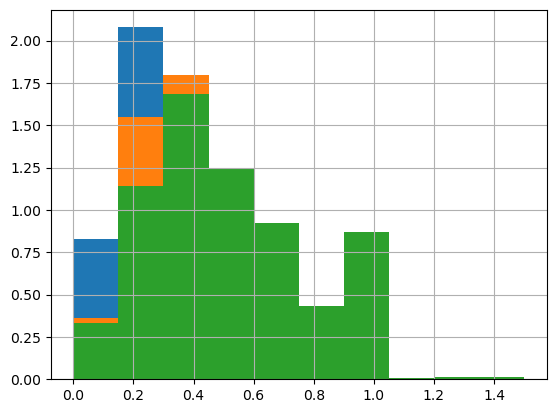

In [ ]:
plt.hist(temp_0.cer, range = (0,1.5), density=True)
plt.hist(temp_1.cer, range = (0,1.5), density=True)
plt.hist(temp_2.cer, range = (0,1.5), density=True)
plt.grid();

In [77]:
temp_3 = metric_df[(metric_df['cer']<=1) & (metric_df['acc'] == 0)]

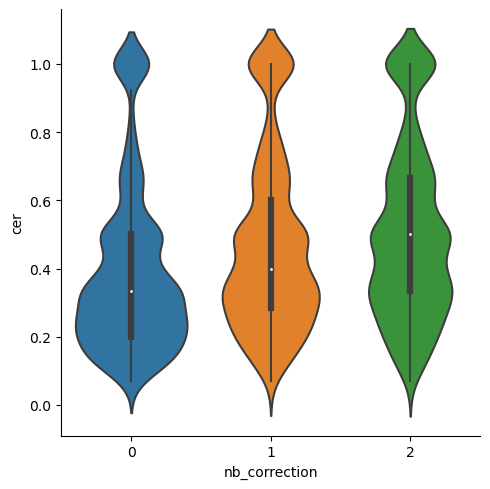

In [43]:
sns.catplot(data = temp_3, x = 'nb_correction', y = 'cer', kind='violin')

<AxesSubplot:xlabel='nb_correction', ylabel='count'>

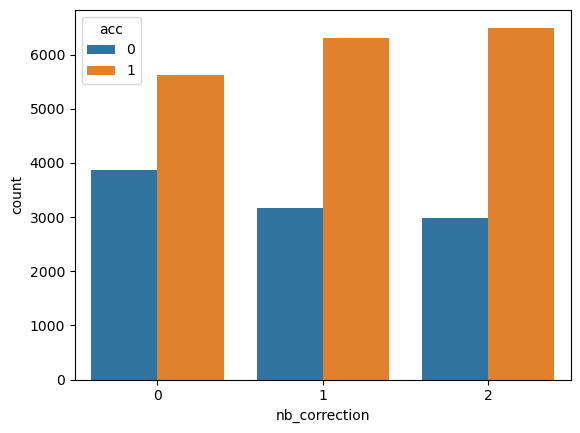

In [78]:
temp_4 = metric_df
sns.countplot(data = temp_4, x = 'nb_correction', hue='acc')

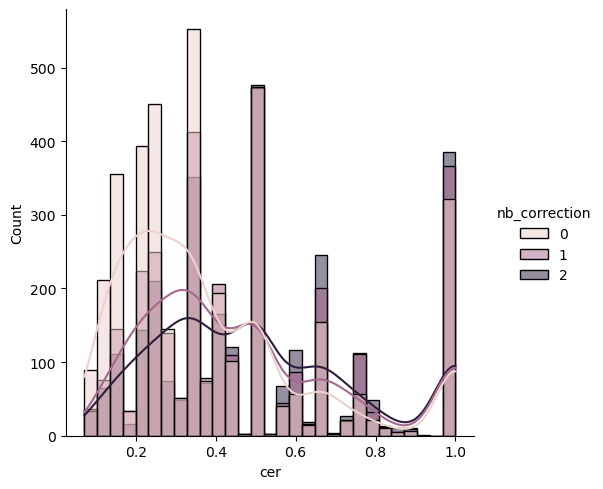

In [79]:
temp_5 = metric_df[(metric_df['cer']<=1) & (metric_df['acc'] == 0)]
sns.displot(data = temp_5, x = 'cer', hue='nb_correction', kde=True)

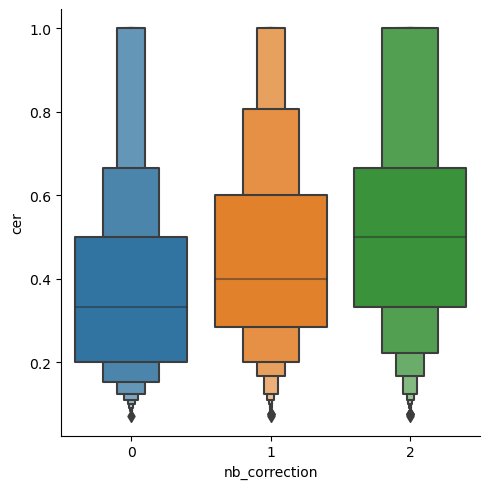

In [80]:
temp_6 = metric_df[(metric_df['cer']<=1) & (metric_df['acc'] == 0)]
sns.catplot(data = temp_6, x = 'nb_correction', y='cer', kind = 'boxen')

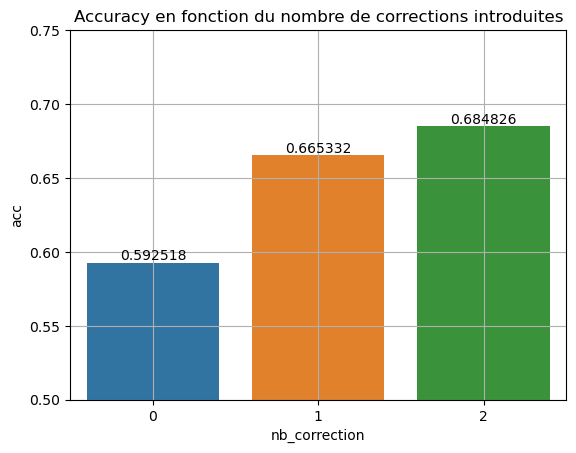

In [91]:
ax = sns.barplot(data=metric_df, x='nb_correction', y = 'acc', errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('Accuracy en fonction du nombre de corrections introduites')
plt.ylim(.5, .75)
plt.grid();

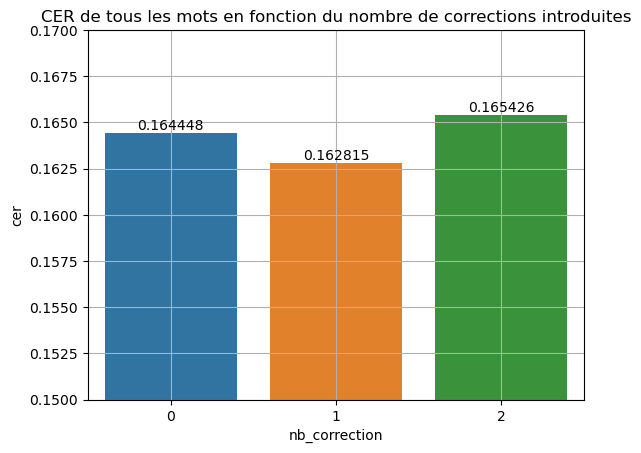

In [102]:
ax = sns.barplot(data=metric_df, x='nb_correction', y = 'cer', errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('CER de tous les mots en fonction du nombre de corrections introduites')
plt.ylim(.15, .17)
plt.grid();

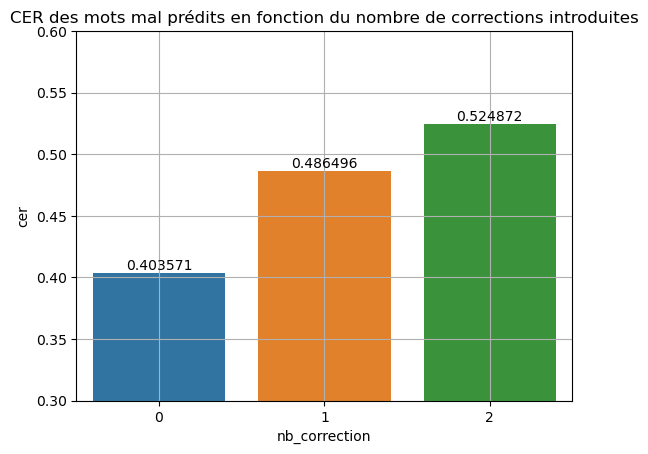

In [103]:
ax = sns.barplot(data=metric_df[metric_df['acc']==0], x='nb_correction', y = 'cer', errwidth=0)
ax.bar_label(ax.containers[0])
plt.title('CER des mots mal prédits en fonction du nombre de corrections introduites')
plt.ylim(.3, .6)
plt.grid();

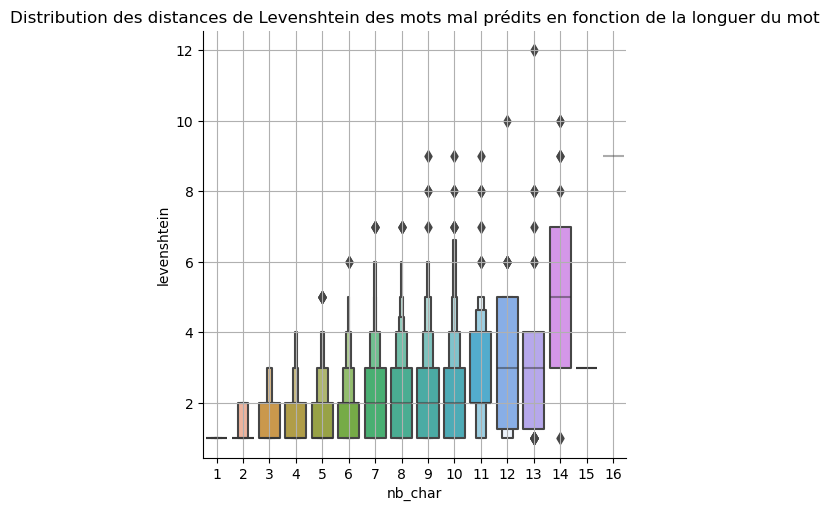

In [122]:
temp_7 = metric_df[(metric_df['cer']<=1) & (metric_df['acc'] == 0)& (metric_df['nb_correction'] == 0)]
sns.catplot(data = temp_7, x = 'nb_char', y='levenshtein', kind='boxen')
plt.title('Distribution des distances de Levenshtein des mots mal prédits en fonction de la longuer du mot')
plt.grid();

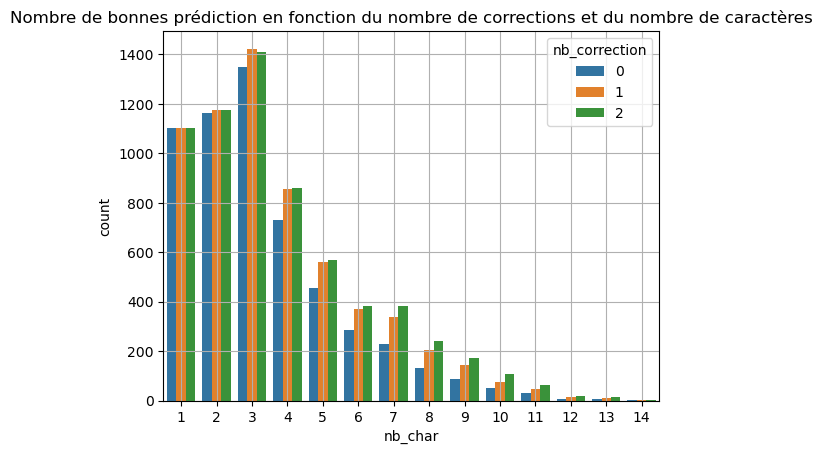

In [127]:
temp_8 = metric_df[(metric_df['acc'] == 1)]
sns.countplot(data = temp_8, x = 'nb_char', hue='nb_correction')
plt.title('Nombre de bonnes prédiction en fonction du nombre de corrections et du nombre de caractères')
plt.grid();

In [ ]:
# conclusion : il y 26 mots (<0,5%) qui ont un score CER > 1

In [167]:
# investigation cer > 1

temp_0 = metric_df_0[metric_df_0['cer']>1]

In [169]:
temp_0.head(26)

,test,prediction,nb_correction,levenshtein,cer,wer
69,#,ei,0,2,2.000000,0
218,#,taras,0,5,5.000000,0
1242,was,lliss,0,4,1.333333,0
1271,"""",il,0,2,2.000000,0
1998,#,pha,0,3,3.000000,0
2660,a,ol,0,2,2.000000,0
2900,#,Sok,0,3,3.000000,0
3103,#,poop,0,4,4.000000,0
3231,him,hiiree,0,4,1.333333,0
3566,and,oiat,0,4,1.333333,0


<AxesSubplot:title={'center':'levenshtein'}, xlabel='nb_correction'>

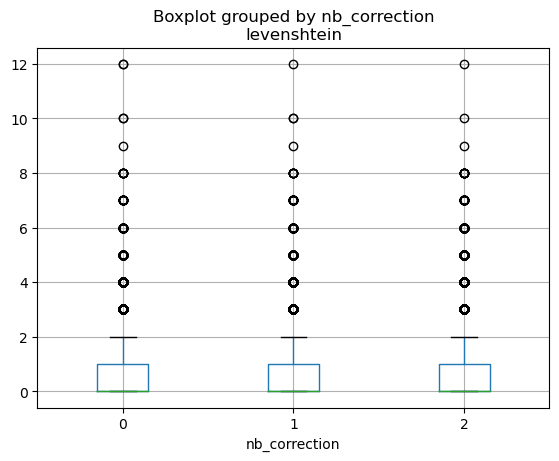

In [145]:
temp.boxplot(column='levenshtein', by='nb_correction')

******************************************************

In [95]:
# OLD
# Distance de Levenshtein pour l'influence avec correction ortographique

#lev_abs = ld_util.levenshtein_distance(proposed_correction, y_test)
#lev_rel = lev_abs / len(y_test)

#print('Score Levenshtein absolu : ', lev_abs)
#print('Scode Levenshtein relatif :', lev_rel)

Score Levenshtein absolu :  2992
Scode Levenshtein relatif : 0.3152792413066386


In [98]:
# Avec le correcteur ortographique simple, on obtient une référence de score de Levenshtein relatif de 0,31.
# Soit, une réduction de la distance de 24% par rapport à l'entrainement de base sans correction ortographique

In [ ]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

In [71]:
correction('The')

'the'

In [ ]:
# correction orthographique v2, (CTC prob)

In [12]:
y_pred.shape

(9490, 32, 100)

In [32]:
# Utilisation du beam search decoder au lieu du greedy decoder
# Ceci permet d'avoir accès au top n des chemins de caractères
# A CONSOLIDER : Définition du beam_width à revoir

decoded, log_probabilities = tf.nn.ctc_beam_search_decoder(
    tf.transpose(y_pred, (1, 0, 2)),
    [y_pred.shape[1]]*y_pred.shape[0],
    beam_width=5,
    top_paths=3
)

In [39]:
tf.sparse.to_dense(decoded[0])[0]

<tf.Tensor: shape=(16,), dtype=int64, numpy=array([53,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])>

In [51]:
for i in range(10):
    print(y_test[i])
    # on commence par la prédiction la plus probable
    predicted_codes = decoded[0]
    
    predicted_codes = tf.cast(predicted_codes, tf.int32)
    codes = tf.sparse.to_dense(predicted_codes)[i]
    print(codes)
    text = decode_codes_test(codes, rss.charList)
    print(text)
    #text = tf.sparse.to_dense(text).numpy().astype(str)

'
tf.Tensor([53  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b',' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
the
tf.Tensor([19  7  4  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b't' b'h' b'e' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
#
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
tf.Tensor(
[b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
before
tf.Tensor([ 1  4  5  8 17  4  0  0  0  0  0  0  0  0  0  0], shape=(16,), dtype=int32)
tf.Tensor(
[b'b' b'e' b'f' b'i' b'r' b'e' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'a'], shape=(16,), dtype=string)
and
tf.Tensor([0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
tf.Tensor(
[b'a' b'd' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a' b'a'
 b'a' b'

In [30]:
predicted_codes = decoded[0]

codes = tf.cast(predicted_codes, tf.int32)
text = ld_util.decode_codes(codes, rss.charList)
text = tf.sparse.to_dense(text).numpy().astype(str)

print(text)

[[',' '' '' ... '' '' '']
 ['t' 'h' 'e' ... '' '' '']
 ['a' '' '' ... '' '' '']
 ...
 [',' '' '' ... '' '' '']
 ['y' 'o' 'u' ... '' '' '']
 ['i' 'n' '' ... '' '' '']]


In [23]:
tf.sparse.to_dense(codes)

<tf.Tensor: shape=(9490, 16), dtype=int32, numpy=
array([[53,  0,  0, ...,  0,  0,  0],
       [19,  7,  4, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [53,  0,  0, ...,  0,  0,  0],
       [24, 14, 20, ...,  0,  0,  0],
       [ 8, 13,  0, ...,  0,  0,  0]], dtype=int32)>

In [13]:
predicted_codes, neg_sum_logits = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(y_pred, (1, 0, 2)),
        [y_pred.shape[1]]*y_pred.shape[0]
    )

codes = tf.cast(predicted_codes[0], tf.int32)
text = ld_util.decode_codes(codes, rss.charList)
text = tf.sparse.to_dense(text).numpy().astype(str)

print(text)

[[',' '' '' ... '' '' '']
 ['t' 'h' 'e' ... '' '' '']
 ['a' '' '' ... '' '' '']
 ...
 [',' '' '' ... '' '' '']
 ['y' 'o' 'u' ... '' '' '']
 ['i' 'n' '' ... '' '' '']]


In [22]:
codes

In [34]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)

def greedy_decoder(logits, char_list):
    # ctc beam search decoder
    predicted_codes, _ = tf.nn.ctc_greedy_decoder(
        # shape of tensor [max_time x batch_size x num_classes] 
        tf.transpose(logits, (1, 0, 2)),
        [logits.shape[1]]*logits.shape[0]
    )
    # convert to int32
    codes = tf.cast(predicted_codes[0], tf.int32)
    # Decode the index of caracter
    text = decode_codes(codes, char_list)
    # Convert a SparseTensor to string
    text = tf.sparse.to_dense(text).numpy().astype(str)
    return list(map(lambda x: ''.join(x), text))
    

In [ ]:
predicted_transcriptions = ld_util.greedy_decoder(y_pred, rss.charList)
list(zip(predicted_transcriptions, y_test[:10]))

In [52]:
def decode_codes_test(codes, charList):
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            np.arange(len(charList)),
            charList,
            key_dtype=tf.int32
        ),
        '',
        name='id2char'
    )
    return table.lookup(codes)

In [ ]:
#